In [447]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.6f}'.format
plt.style.use("seaborn-v0_8")
#from IterativeBase import IterativeBase
import yfinance as yf

In [448]:
class IterativeBase():

    def __init__(self, symbol, start, end, amount, use_spread=True):
        self.end = end
        self.use_spread = use_spread
        self.symbol = symbol
        self.start = start
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.data = self.get_data()
        self.balance_history = pd.DataFrame(columns=['Datetime', 'balance'])

    def get_data(self):
  #      df = pd.read_csv('eurusd_minute.csv', usecols=['Date', 'Time', 'BC', 'AC'])
  #      df['Datetime'] = df['Date'] + ' ' + df['Time']
  #      df['Datetime'] = pd.to_datetime(df['Datetime'])
  #      df = df.drop(['Date', 'Time'], axis=1)
  #      df = df.set_index('Datetime')
  #      df.rename(columns={"BC": "bid", "AC": "ask"}, inplace=True)
  #      df.bid = df.bid.ffill()
  #      df.ask = df.ask.ffill()
  #      df['price'] = (df['bid'] + df['ask']) / 2
  #      df['spread'] = df['ask'] - df['bid']
        df = yf.download(self.symbol, self.start, self.end, interval='1d').Close.to_frame()
        df.rename(columns={"Close": "price"}, inplace=True)
        spread = 1.5 * 0.0001
        halfspread = spread / 2
        ptc = halfspread / df.price.mean()
        df['bid'] = df.price - ptc
        df['ask'] = df.price + ptc
        df['spread'] = spread * df.price.mean()
  
        df['returns'] = np.log(df['price'].div(df['price'].shift(1)))
     #   df = df.resample('1d').mean().ffill()
        return df

    def buy(self, bar, units=None, amount=None):
        date, bid, ask, spread = self.get_values(bar)
        if amount is not None:
            units = int(amount / ask)
        self.current_balance -= units * ask
        self.units += units
        self.trades += 1
        trading_cost = units * spread / 2
        self.balance_history.loc[len(self.balance_history)] = {'Datetime': date, 'balance': (
                    self.current_balance - self.units * (bid + ask) / 2)}
        print("{} | Buying {} for {} | Trading Cost is {} |  nav: {}".format(date, units, round(ask, 2), trading_cost,  self.current_balance - self.units * (bid + ask) / 2))

    def sell(self, bar, units=None, amount=None):
        date, bid, ask, spread = self.get_values(bar)
        if amount is not None:
            units = int(amount / bid)
        self.current_balance += units * bid
        self.units -= units
        self.trades += 1
        trading_cost = np.abs(units) * spread / 2
        self.balance_history.loc[len(self.balance_history)] = {'Datetime': date, 'balance': (
                    self.current_balance - self.units * (bid + ask) / 2)}
        print("{} | Selling {} for {} | Trading Cost is {} | nav: {}".format(date, units, round(bid, 2), trading_cost,  self.current_balance - self.units * (bid + ask) / 2))

    def plot_data(self, cols=None):
        if cols == None:
            cols = 'price'
        self.data[cols].plot(figsize=(12, 8), title=self.symbol)

    def get_values(self, bar):
        date = str(self.data.index[bar])
        bid = round(self.data.bid.iloc[bar], 6)
        ask = round(self.data.ask.iloc[bar], 6)
        spread = round(self.data.spread.iloc[bar], 6)
        return date, bid, ask, spread

    def print_current_balance(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))

    def print_current_position(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = (bid + ask) / 2
        cpv = self.units * price
        print("{} | Current Position Value: {}".format(date, round(cpv, 2)))

    def print_current_nav(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = (bid + ask) / 2
        nav = self.current_balance + self.units * price
        print("{} | Current Nav: {}".format(date, round(nav, 2)))

    def close_pos(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = ask if self.units < 0 else bid
        trading_cost = np.abs(self.units) * spread / 2
        print(75 * '-')
        print("{} | Closing Position of {} for {} | Trading Cost is {} | nav: {} ".format(date, self.units, price, trading_cost,  self.current_balance + self.units * (bid + ask) / 2))
        print(75 * '-')
        self.current_balance += self.units * price
        self.units = 0
        self.trades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | Net Performance (%) = {}".format(date, round(perf, 2)))
        print("{} | Number of trades executed = {}".format(date, self.trades))
        print(75 * '-')

In [449]:
class IterativeBacktest(IterativeBase):
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy(bar, units = -self.units)
        if units:
            self.buy(bar, units = units)
        elif amount:
            if amount == 'all':
                amount = self.current_balance
            self.buy(bar, amount = amount)
            
    def go_short(self, bar, units = None, amount = None):
        if self.position == 1:
            self.sell(bar, units = self.units)
        if units:
            self.sell(bar, units = units)
        elif amount:
            if amount == 'all':
                amount = self.current_balance
            self.sell(bar, amount = amount)
            
    def test_sma_strategy(self, sma_s, sma_l):
        stm = "Testing SMA | {} | {} Sma Short | {} Sma Long".format(self.symbol, sma_s, sma_l)
        print('-'*75)
        print(stm)
        print('-'*75)
        #reset
        self.position=0
        self.trades=0
        self.current_balance=self.initial_balance
        self.data = self.get_data()
        
        self.data['sma_short'] = self.data['price'].rolling(sma_s).mean()
        self.data['sma_long'] =  self.data['price'].rolling(sma_l).mean()
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data) -1): # all bars
            if self.data['sma_short'].iloc[bar] > self.data['sma_long'].iloc[bar]:
                #print('point2 {}'.format(bar))
                if self.position in [0,-1]:
                    self.go_long(bar, amount='all')
                    self.position=1
                    print("bar: {} | long: sma s {} > sma l {}".format(bar, self.data['sma_short'].iloc[bar],  self.data['sma_long'].iloc[bar]))
            elif self.data['sma_short'].iloc[bar] < self.data['sma_long'].iloc[bar]:
                #print('point4 {}'.format(bar))
                if self.position in [0,1]:
                    self.go_short(bar, amount='all')
                    self.position=-1
                    print("bar: {} | short: sma s {} < sma l {}".format(bar, self.data['sma_short'].iloc[bar],  self.data['sma_long'].iloc[bar]))
        self.close_pos(bar+1) # close position at the last bar
        
    def test_mom_strategy(self, window):
        stm = "Testing Momentum | {} | {} Window".format(self.symbol, window)
        print('-'*75)
        print(stm)
        print('-'*75)
        #reset
        self.position=0
        self.trades=0
        self.current_balance=self.initial_balance
        self.data = self.get_data()
        self.data['rolling_returns'] = self.data['returns'].rolling(window).mean()
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data) -1): # all bars
            if self.data['rolling_returns'].iloc[bar] >= 0:
                if self.position in [0,-1]:
                    self.go_long(bar, amount='all')
                    self.position=1
                    print("bar: {} | long: rolling returns {} >= 0".format(bar, self.data['rolling_returns'].iloc[bar]))
            elif self.data['rolling_returns'].iloc[bar] < 0:
                if self.position in [0,1]:
                    self.go_short(bar, amount='all')
                    self.position=-1
                    print("bar: {} | short: rolling returns {} < 0".format(bar, self.data['rolling_returns'].iloc[bar]))
        self.close_pos(bar+1) # close position at the last bar
    
    def test_bollinger_strategy(self, sma, dev):
        stm = "Testing Bollinger | {} | {} Sma | {} Dev".format(self.symbol, sma, dev)
        print('-'*75)
        print(stm)
        print('-'*75)
        #reset
        self.position=0
        self.trades=0
        self.current_balance=self.initial_balance
        self.data = self.get_data()
        self.data['sma'] = self.data['price'].rolling(sma).mean()
        self.data['upper'] = self.data['sma'] + self.data['price'].rolling(sma).std() * dev 
        self.data['lower'] = self.data['sma'] - self.data['price'].rolling(sma).std() * dev 
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data) -1): # all bars
            if self.position == 0:
                if self.data['price'].iloc[bar] < self.data['lower'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position=1
                elif self.data['price'].iloc[bar] > self.data['upper'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position=-1
            elif self.position == 1:
                if self.data['price'].iloc[bar] > self.data['sma'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position=-1
                else: 
                    self.sell(bar, units = self.units) # go neutral
                    self.position=0
            elif self.position == -1:
                if self.data['price'].iloc[bar] < self.data['sma'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position=1
                else: 
                    self.buy(bar, units = self.units) # go neutral
                    self.position=0
        self.close_pos(bar+1) # close position at the last bar
        

In [450]:
bc = IterativeBacktest("EURUSD=X", '2006-12-31', '2019-06-30', 100000)
bc.data

[*********************100%%**********************]  1 of 1 completed


,price,bid,ask,spread,returns
Date,,,,,
2007-01-01,1.321895,1.321836,1.321953,0.000192,NaN
2007-01-02,1.327598,1.327539,1.327657,0.000192,0.004305
2007-01-03,1.317107,1.317048,1.317165,0.000192,-0.007934
2007-01-04,1.309295,1.309236,1.309353,0.000192,-0.005949
2007-01-05,1.298499,1.298440,1.298558,0.000192,-0.008280
...,...,...,...,...,...
2019-06-24,1.138472,1.138414,1.138531,0.000192,0.007859
2019-06-25,1.140030,1.139971,1.140088,0.000192,0.001367
2019-06-26,1.136997,1.136938,1.137055,0.000192,-0.002664


In [451]:
bc.test_sma_strategy(50, 200)

---------------------------------------------------------------------------
Testing SMA | EURUSD=X | 50 Sma Short | 200 Sma Long
---------------------------------------------------------------------------


[*********************100%%**********************]  1 of 1 completed


2007-10-08 00:00:00 | Buying 71176 for 1.4 | Trading Cost is 6.832896 |  nav: -99995.698588
bar: 0 | long: sma s 1.3801432633399964 > sma l 1.3466968107223511
2008-09-23 00:00:00 | Selling 71176 for 1.47 | Trading Cost is 6.832896 | nav: 104574.196816
2008-09-23 00:00:00 | Selling 71176 for 1.47 | Trading Cost is 6.832896 | nav: 313726.616628
bar: 230 | short: sma s 1.517415361404419 < sma l 1.51794318318367
2009-05-27 00:00:00 | Buying 71176 for 1.38 | Trading Cost is 6.832896 |  nav: 110679.74527200001
2009-05-27 00:00:00 | Buying 80002 for 1.38 | Trading Cost is 7.680192 |  nav: -110673.42841899997
bar: 406 | long: sma s 1.3413412261009217 > sma l 1.3410110968351363
2010-02-09 00:00:00 | Selling 80002 for 1.38 | Trading Cost is 7.680192 | nav: 110255.49466600003
2010-02-09 00:00:00 | Selling 80002 for 1.38 | Trading Cost is 7.680192 | nav: 330769.52737900004
bar: 590 | short: sma s 1.4332055974006652 < sma l 1.4353892868757248
2010-10-18 00:00:00 | Buying 80002 for 1.4 | Trading Cos

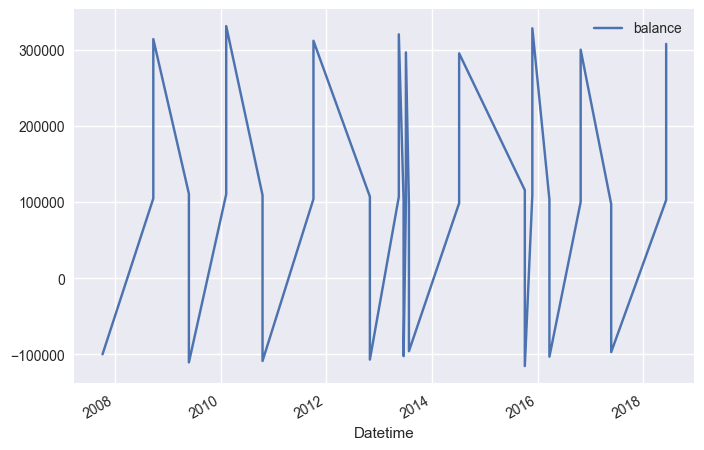

In [452]:
bc.balance_history['Datetime'] = pd.to_datetime(bc.balance_history['Datetime'])
bc.balance_history = bc.balance_history.set_index('Datetime')
bc.balance_history.plot()
plt.show()

In [453]:
bc.balance_history

,balance
Datetime,
2007-10-08,-99995.698588
2008-09-23,104574.196816
2008-09-23,313726.616628
2009-05-27,110679.745272
2009-05-27,-110673.428419
2010-02-09,110255.494666
2010-02-09,330769.527379
2010-10-18,108788.017980
2010-10-18,-108780.878470


In [454]:
bc2 = IterativeBacktest("EURUSD=X", '2006-12-31', '2019-06-30', 100000)
bc2.data

[*********************100%%**********************]  1 of 1 completed


,price,bid,ask,spread,returns
Date,,,,,
2007-01-01,1.321895,1.321836,1.321953,0.000192,NaN
2007-01-02,1.327598,1.327539,1.327657,0.000192,0.004305
2007-01-03,1.317107,1.317048,1.317165,0.000192,-0.007934
2007-01-04,1.309295,1.309236,1.309353,0.000192,-0.005949
2007-01-05,1.298499,1.298440,1.298558,0.000192,-0.008280
...,...,...,...,...,...
2019-06-24,1.138472,1.138414,1.138531,0.000192,0.007859
2019-06-25,1.140030,1.139971,1.140088,0.000192,0.001367
2019-06-26,1.136997,1.136938,1.137055,0.000192,-0.002664


In [455]:
bc2.test_mom_strategy(3)

[*********************100%%**********************]  1 of 1 completed

---------------------------------------------------------------------------
Testing Momentum | EURUSD=X | 3 Window
---------------------------------------------------------------------------
2007-01-04 00:00:00 | Selling 76380 for 1.31 | Trading Cost is 7.33248 | nav: 300003.35959
bar: 0 | short: rolling returns -0.0031924530651762442 < 0
2007-01-16 00:00:00 | Buying 76380 for 1.29 | Trading Cost is 7.33248 |  nav: 101311.52098
2007-01-16 00:00:00 | Buying 78410 for 1.29 | Trading Cost is 7.52736 |  nav: -101305.52533500001
bar: 8 | long: rolling returns 0.0006453847554026385 >= 0
2007-01-24 00:00:00 | Selling 78410 for 1.3 | Trading Cost is 7.52736 | nav: 101638.49067999999
2007-01-24 00:00:00 | Selling 78410 for 1.3 | Trading Cost is 7.52736 | nav: 304918.68957
bar: 14 | short: rolling returns -0.00015559340401609997 < 0
2007-01-29 00:00:00 | Buying 78410 for 1.3 | Trading Cost is 7.52736 |  nav: 101629.2383
2007-01-29 00:00:00 | Buying 78396 for 1.3 | Trading Cost is 7.526016 |  nav

2007-09-05 00:00:00 | Buying 70336 for 1.37 | Trading Cost is 6.752256 |  nav: -96035.45116600006
bar: 174 | long: rolling returns 0.0002911818740172903 >= 0
2007-09-17 00:00:00 | Selling 70336 for 1.39 | Trading Cost is 6.752256 | nav: 97517.58022599995
2007-09-17 00:00:00 | Selling 70336 for 1.39 | Trading Cost is 6.752256 | nav: 292555.299074
bar: 181 | short: rolling returns -0.0010322057205830702 < 0
2007-09-18 00:00:00 | Buying 70336 for 1.4 | Trading Cost is 6.752256 |  nav: 96700.83859399996
2007-09-18 00:00:00 | Buying 69168 for 1.4 | Trading Cost is 6.640128 |  nav: -96696.31322200004
bar: 182 | long: rolling returns 0.0027057904248812287 >= 0
2007-10-02 00:00:00 | Selling 69168 for 1.42 | Trading Cost is 6.640128 | nav: 97883.26555399995
2007-10-02 00:00:00 | Selling 69168 for 1.42 | Trading Cost is 6.640128 | nav: 293653.36394599994
bar: 192 | short: rolling returns -1.0119220276531374e-17 < 0
2007-10-10 00:00:00 | Buying 69168 for 1.41 | Trading Cost is 6.640128 |  nav: 97

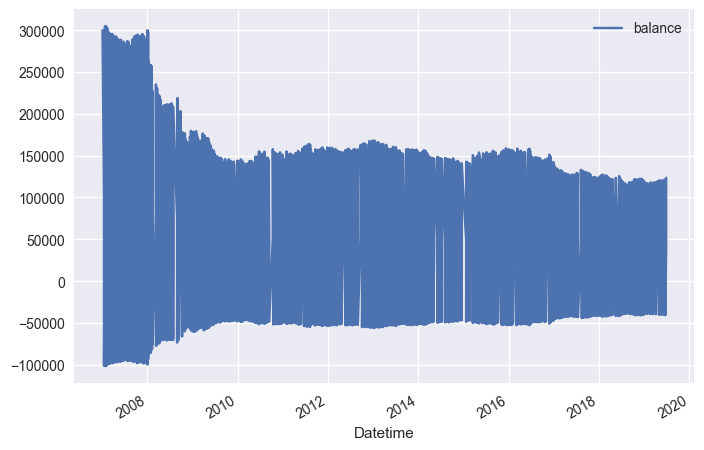

In [456]:
bc2.balance_history['Datetime'] = pd.to_datetime(bc2.balance_history['Datetime'])
bc2.balance_history = bc2.balance_history.set_index('Datetime')
bc2.balance_history.plot()
plt.show()

In [457]:
bc3 = IterativeBacktest("EURUSD=X", '2006-12-31', '2019-06-30', 100000)
bc3.data

[*********************100%%**********************]  1 of 1 completed


,price,bid,ask,spread,returns
Date,,,,,
2007-01-01,1.321895,1.321836,1.321953,0.000192,NaN
2007-01-02,1.327598,1.327539,1.327657,0.000192,0.004305
2007-01-03,1.317107,1.317048,1.317165,0.000192,-0.007934
2007-01-04,1.309295,1.309236,1.309353,0.000192,-0.005949
2007-01-05,1.298499,1.298440,1.298558,0.000192,-0.008280
...,...,...,...,...,...
2019-06-24,1.138472,1.138414,1.138531,0.000192,0.007859
2019-06-25,1.140030,1.139971,1.140088,0.000192,0.001367
2019-06-26,1.136997,1.136938,1.137055,0.000192,-0.002664


In [458]:
bc3.test_bollinger_strategy(20,2)

[*********************100%%**********************]  1 of 1 completed


---------------------------------------------------------------------------
Testing Bollinger | EURUSD=X | 20 Sma | 2 Dev
---------------------------------------------------------------------------
2007-02-14 00:00:00 | Selling 76107 for 1.31 | Trading Cost is 7.306272 | nav: 300003.4499215
2007-02-15 00:00:00 | Buying -76107 for 1.31 | Trading Cost is -7.306272 |  nav: 499905.449212
2007-03-15 00:00:00 | Selling 225840 for 1.33 | Trading Cost is 21.68064 | nav: 1102112.444689
2007-03-16 00:00:00 | Buying -378054 for 1.33 | Trading Cost is -36.293184000000004 |  nav: 2110448.433112
2007-03-21 00:00:00 | Selling 823569 for 1.34 | Trading Cost is 79.062624 | nav: 4323538.0449685
2007-03-22 00:00:00 | Buying -1579677 for 1.33 | Trading Cost is -151.648992 |  nav: 8526054.657235
2007-04-12 00:00:00 | Selling 3197329 for 1.35 | Trading Cost is 306.943584 | nav: 17202572.749438997
2007-04-13 00:00:00 | Buying -6356683 for 1.35 | Trading Cost is -610.241568 |  nav: 34411709.157872
2007-04-16 

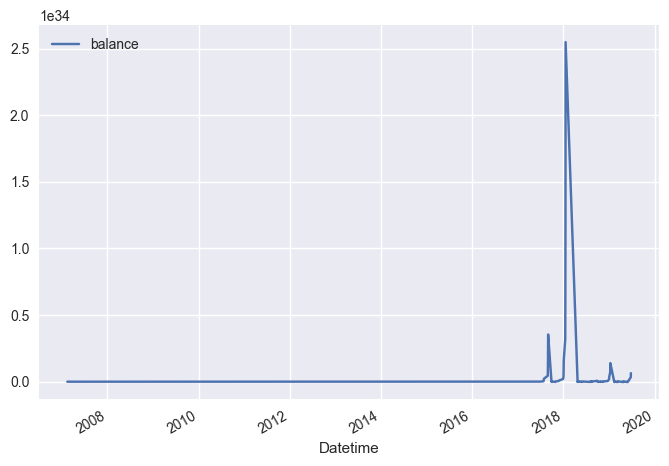

In [459]:
bc3.balance_history['Datetime'] = pd.to_datetime(bc3.balance_history['Datetime'])
bc3.balance_history = bc3.balance_history.set_index('Datetime')
bc3.balance_history.plot()
plt.show()

In [460]:
bc3.balance_history

,balance
Datetime,
2007-02-14,300003.449921
2007-02-15,499905.449212
2007-03-15,1102112.444689
2007-03-16,2110448.433112
2007-03-21,4323538.044968
...,...
2019-05-31,30431003723952601968660973617152.000000
2019-06-10,91294583858556903604234242490368.000000
2019-06-11,152144775993568872515412791656448.000000


In [461]:
bc3.data.describe()

,price,bid,ask,spread,returns,sma,upper,lower
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1.278181,1.278123,1.278240,0.000192,-0.000040,1.278670,1.304718,1.252622
std,0.130693,0.130693,0.130693,0.000000,0.008175,0.129554,0.135660,0.125593
min,1.039047,1.038989,1.039106,0.000192,-0.143324,1.047993,1.061013,1.028974
25%,1.144617,1.144558,1.144675,0.000192,-0.003396,1.144156,1.163792,1.129617
50%,1.298802,1.298744,1.298861,0.000192,0.000020,1.300274,1.327065,1.272280
75%,1.367451,1.367393,1.367510,0.000192,0.003433,1.365748,1.391008,1.344728
max,1.598798,1.598739,1.598856,0.000192,0.159632,1.579446,1.645014,1.559098
